In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import joblib
import random


In [9]:
def preprocess_image(image, blur_kernel=(5, 5), threshold_val=50):
    """
    Convert the image to grayscale, blur it, apply Otsu thresholding and morphological closing.
    This helps extract the hand silhouette.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, blur_kernel, 0)
    # Apply Otsu thresholding
    ret, thresh = cv2.threshold(blurred, threshold_val, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Use a morphological closing to remove small holes in the silhouette
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return closed

def get_all_contours(binary_image):
    """
    Finds all external contours in the binary image and returns an image 
    with only the contours (outlines) drawn.
    """
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(binary_image)
    if contours:  # Check if any contours were found
        cv2.drawContours(contour_image, contours, -1, 255, thickness=1)
    return contour_image


In [10]:
def compute_hu_moments(binary_image):
    """
    Computes the seven Hu invariant moments from the binary image.
    Log-transform is applied to better spread the values.
    """
    moments = cv2.moments(binary_image)
    huMoments = cv2.HuMoments(moments).flatten()
    # Log scale transform
    for i in range(len(huMoments)):
        if huMoments[i] != 0:
            huMoments[i] = -1 * np.sign(huMoments[i]) * np.log10(np.abs(huMoments[i]))
    return huMoments

import numpy as np

def compute_fourier_descriptor(contour, num_coeff=10):
    """
    Computes a Fourier descriptor for a given contour with invariance to translation,
    rotation, and scale. The contour is expected to be in a format that is either (N, 2) 
    or (N, 1, 2) (as returned by cv2.findContours).

    Parameters:
        contour (np.ndarray): The contour whose Fourier descriptor will be computed.
        num_coeff (int): The number of Fourier coefficients (excluding the DC term) to keep.

    Returns:
        np.ndarray or None: The normalized Fourier descriptor (a 1D array of complex numbers)
                              or None if the computation fails.
    """
    if contour is None or len(contour) < 3:
        return None

    # Ensure contour is in shape (N,2)
    if contour.ndim == 3:
        contour_array = contour[:, 0, :]  # Shape (N, 2)
    else:
        contour_array = contour

    # Subtract the centroid for translation invariance
    centroid = np.mean(contour_array, axis=0)
    contour_array = contour_array - centroid

    # Convert the 2D coordinates into a complex representation (x + i*y)
    complex_contour = contour_array[:, 0] + 1j * contour_array[:, 1]

    # Compute the Fourier Transform of the contour
    fourier = np.fft.fft(complex_contour)

    # Remove the DC component (which is zero or near zero after centering)
    descriptor = fourier[1:num_coeff+1]

    # Check that we have a valid first coefficient to use for normalization
    if np.abs(descriptor[0]) == 0:
        return None

    # Rotation invariance:
    # Align the phase by multiplying by the conjugate phase of the first coefficient
    theta = np.angle(descriptor[0])
    descriptor = descriptor * np.exp(-1j * theta)

    # Scale invariance:
    # Normalize by the magnitude of the first coefficient (which is now real)
    norm_factor = np.abs(descriptor[0])
    if norm_factor > 0:
        descriptor = descriptor / norm_factor
    else:
        return None

    return descriptor



In [4]:
import os
import cv2
import random
import joblib
import time
import numpy as np

# Define your preprocessing functions: preprocess_image, compute_hu_moments, get_all_contours, compute_fourier_descriptor

database_path = 'ASL\\input\\asl_alphabet_train\\asl_alphabet_train'
pkl_path = "ASL\\output\\opencv_database.pkl"
train_images_per_class = 10  # Number of training images per class
test_images_per_class = 100   # Number of test images per class

# Start timing database creation
db_start_time = time.time()

if os.path.exists(pkl_path):
    db_descriptors = joblib.load(pkl_path)
    print("Loaded database from", pkl_path)
else:
    db_descriptors = {'train': {}, 'test': {}}
    
    # Process each class folder in the database
    for label in os.listdir(database_path):
        label_path = os.path.join(database_path, label)
        if not os.path.isdir(label_path):
            continue
            
        db_descriptors['train'][label] = []
        db_descriptors['test'][label] = []  # We'll store file paths for test images
        
        # Get all image files and shuffle them
        img_files = os.listdir(label_path)
        random.shuffle(img_files)
        
        count = 0
        for img_file in img_files:
            if count >= train_images_per_class + test_images_per_class:
                break
                
            img_path = os.path.join(label_path, img_file)
            image = cv2.imread(img_path)
            if image is None:
                continue
                
            # Preprocess the image to extract the hand silhouette
            processed = preprocess_image(image)
            # Compute Hu invariant moments from the binary silhouette
            hu = compute_hu_moments(processed)
            # Extract the largest contour from the preprocessed image
            contour = get_all_contours(processed)
            # Compute Fourier descriptors from the contour
            fourier = compute_fourier_descriptor(contour)
            if fourier is None:
                continue
                
            # For training images, store the computed descriptors.
            if count < train_images_per_class:
                db_descriptors['train'][label].append((hu, fourier))
            else:
                # For test images, store the file path for deferred preprocessing.
                db_descriptors['test'][label].append(img_path)
                
            count += 1

    # Ensure output directory exists and save the dictionary using joblib
    os.makedirs(os.path.dirname(pkl_path), exist_ok=True)
    joblib.dump(db_descriptors, pkl_path)
    print("Database built and saved to", pkl_path)

# End timing database creation
db_end_time = time.time()
db_creation_time = db_end_time - db_start_time

# Print database creation time and dataset statistics
print("\nDatabase Creation Time: {:.2f} seconds".format(db_creation_time))
print("\nDataset Statistics:")
print(f"Training images per class: {train_images_per_class}")
print(f"Test images per class: {test_images_per_class}")
print("Available labels:", list(db_descriptors['train'].keys()))


Database built and saved to ASL\output\opencv_database.pkl

Database Creation Time: 9.10 seconds

Dataset Statistics:
Training images per class: 10
Test images per class: 100
Available labels: ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Test set evaluation
def match_descriptor(query_descriptor, db_descriptor, weight_hu=0.5, weight_fourier=0.5):
    """
    Compute a weighted Euclidean distance between query and database descriptors.
    """
    hu_query, fourier_query = query_descriptor
    hu_db, fourier_db = db_descriptor
    hu_dist = np.linalg.norm(hu_query - hu_db)
    fourier_dist = np.linalg.norm(fourier_query - fourier_db)
    return weight_hu * hu_dist + weight_fourier * fourier_dist

true_labels = []
predicted_labels = []
all_scores = []
processed_test_images = 0

# Start timing test evaluation
test_start_time = time.time()

# Process each test sample
for label in db_descriptors['test'].keys():
    for test_img_path in db_descriptors['test'][label]:
        # Load the test image
        image = cv2.imread(test_img_path)
        if image is None:
            continue
            
        # Preprocess the test image and compute descriptors on-the-fly
        processed = preprocess_image(image)
        hu_query = compute_hu_moments(processed)
        contour = get_all_contours(processed)
        fourier_query = compute_fourier_descriptor(contour)
        if fourier_query is None:
            continue
            
        test_descriptor = (hu_query, fourier_query)
        scores = {}
        
        # Compare with each descriptor in the training database
        for train_label, descriptors in db_descriptors['train'].items():
            label_scores = []
            for desc in descriptors:
                score = match_descriptor(test_descriptor, desc)
                label_scores.append(score)
            if label_scores:
                scores[train_label] = np.min(label_scores)
        
        if scores:
            recognized_label = min(scores, key=scores.get)
            true_labels.append(label)
            predicted_labels.append(recognized_label)
            # Store scores for ROC AUC calculation
            all_scores.append(scores)
            processed_test_images += 1

# End timing test evaluation
test_end_time = time.time()
evaluation_time = test_end_time - test_start_time
fps = processed_test_images / evaluation_time if evaluation_time > 0 else 0

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Prepare data for ROC AUC calculation
lb = LabelBinarizer()
y_true = lb.fit_transform(true_labels)
# Initialize y_scores as float array
y_scores = np.zeros_like(y_true, dtype=np.float64)

for i, scores in enumerate(all_scores):
    for label, score in scores.items():
        label_idx = lb.transform([label])[0]
        y_scores[i] += label_idx * (1 - score)  # Convert distance to similarity

roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

# Print metrics and FPS
print("\nTest Set Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Processed Test Images:", processed_test_images)
print("Evaluation Time: {:.2f} seconds".format(evaluation_time))
print("FPS (Images per Second): {:.2f}".format(fps))



Test Set Evaluation Metrics:
Accuracy: 0.1800
F1 Score: 0.1829
ROC AUC: 0.6295
Processed Test Images: 2900
Evaluation Time: 16.38 seconds
FPS (Images per Second): 177.10


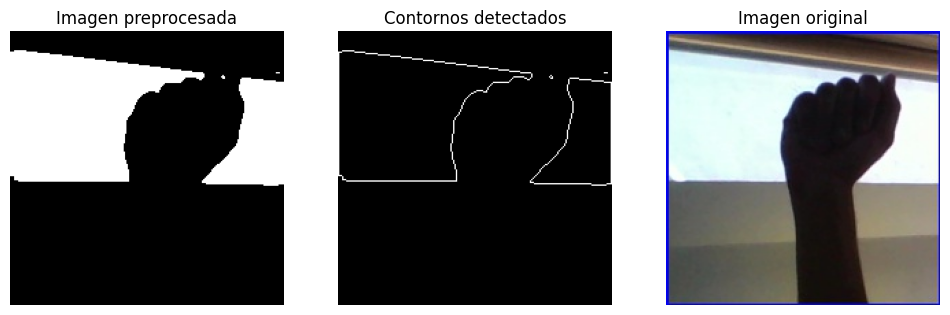

Hu Moments: [  2.796881     5.89514009   8.88460627   8.9609843   17.88400798
  11.90971507 -19.37292321]
Fourier Descriptor: [ 1.        -2.99336912e-17j -0.07286456-1.24334315e-01j
  0.25596199-1.70044713e-01j -0.1249108 -5.81919072e-02j
  0.06816213-1.39644425e-01j -0.12636455+1.92783840e-02j
  0.00194139-8.42400845e-02j -0.08652529+7.56870032e-02j
 -0.00858664-4.47734936e-02j -0.03048103+9.54200070e-02j]


In [12]:
# # Ruta a una imagen de ejemplo (cambia la ruta según tu dataset)
# ruta_imagen = "ASL\\input\\asl_alphabet_test\\asl_alphabet_test\\A_test.jpg"
# imagen = cv2.imread(ruta_imagen)
# if imagen is None:
#     raise Exception("No se pudo cargar la imagen. Revisa la ruta.")

# # Preprocesar la imagen: se extrae la silueta de la mano usando preprocess_image.
# # Esta función convierte la imagen a escala de grises, la suaviza, aplica Otsu y cierra huecos.
# imagen_preprocesada = preprocess_image(imagen)

# # Obtener los contornos de la silueta (se dibujan sobre una imagen en negro)
# imagen_contornos = get_all_contours(imagen_preprocesada)

# # Calcular descriptores clásicos:
# # Hu Moments se calcula sobre la imagen preprocesada (la silueta binaria)
# hu = compute_hu_moments(imagen_preprocesada)
# # El descriptor de Fourier se calcula a partir de los contornos detectados
# fourier = compute_fourier_descriptor(imagen_contornos)

# # Mostrar la imagen preprocesada, la imagen con contornos y la imagen original
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 3, 1)
# plt.imshow(imagen_preprocesada, cmap='gray')
# plt.title("Imagen preprocesada")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(imagen_contornos, cmap='gray')
# plt.title("Contornos detectados")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
# plt.title("Imagen original")
# plt.axis("off")

# plt.show()

# print("Hu Moments:", hu)
# if fourier is not None:
#     print("Fourier Descriptor:", fourier)
# else:
#     print("No se pudo calcular el Fourier Descriptor")
